## Import necessary libraries

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import torch
import cv2 as cv
import torchvision.transforms

## Read in Datasheet with references to images

In [2]:
df = pd.read_csv('FracAtlas/dataset.csv')

## Show example images

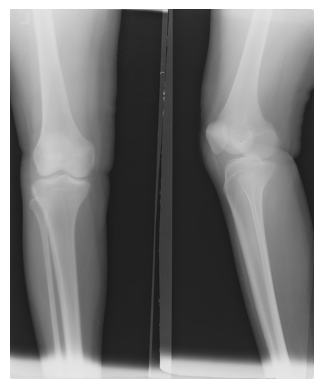

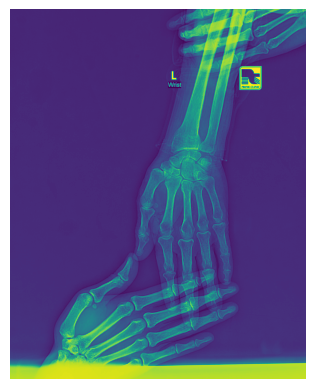

In [3]:
num_fracs = 0 #only show one example for each
num_non_fracs = 0

for index, row in df.iterrows():
    image_id = row['image_id']
    fractured_indicator = row['fractured']
    if fractured_indicator:
        filename = f'FracAtlas/images/Fractured/{image_id}'
    else:
        filename = f'FracAtlas/images/Non_fractured/{image_id}'

    if num_fracs == 0 and fractured_indicator:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_fracs += 1
    
    if num_non_fracs == 0 and not fractured_indicator:
        img = mpimg.imread(filename)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        num_non_fracs += 1

## Transform skeletal images to controlmaps to feed into controlnet and image generation
These controlmaps will be done using the process of image segmentation, generating an image that is easily reproducible by hand to feed into the controlnet and subsequent x-ray image generation.

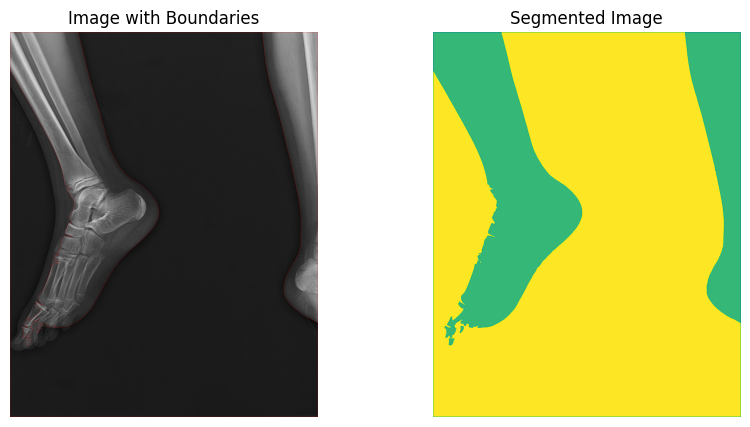

In [25]:
ex = df.loc[10]
image_id = ex['image_id']
fractured_indicator = ex['fractured']
if fractured_indicator:
    filename = f'FracAtlas/images/Fractured/{image_id}'
else:
    filename = f'FracAtlas/images/Non_fractured/{image_id}'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

plt.figure(figsize=(10, 5))  # Set the figure size as needed

# Display the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title('Image with red Boundaries')

# Display the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(markers)
plt.axis('off')
plt.title('Segmented Image')

# Show the plot
plt.show()


## Smooth edges of controlmaps
First attempt using blurring techniques to decrease granularity of controlmaps, kernel size can be adjusted accordingly

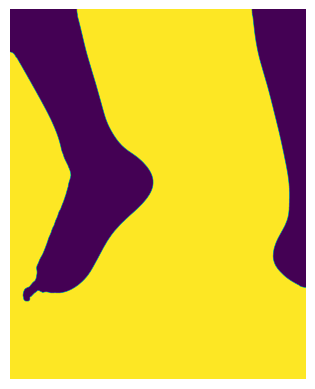

In [40]:
smoothed_markers = cv.blur(markers,(99,99))
plt.imshow(smoothed_markers)
plt.axis('off')
plt.show()